In [1]:
import chess

In [179]:
board = chess.Board()

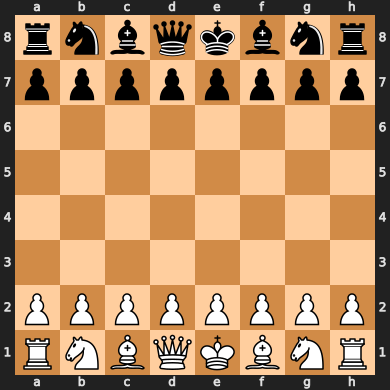

In [180]:
board

In [2]:
import numpy as np

In [3]:
from mlrl.utils.render_utils import svg_to_array

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [5]:
import badgyal

bg = badgyal.BGNet(cuda=True)
board = chess.Board()

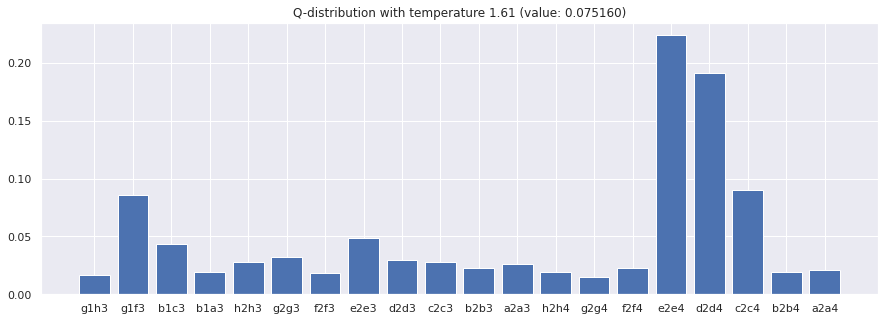

In [6]:
policy, value = bg.eval(board, softmax_temp=1.61)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

plt.figure(figsize=(15, 5))
plt.bar(policy.keys(), policy.values())
plt.title(f'Q-distribution with temperature 1.61 (value: {value:3f})')
plt.show()

In [7]:
a = max(policy, key=policy.get)
board.push(chess.Move.from_uci(a))

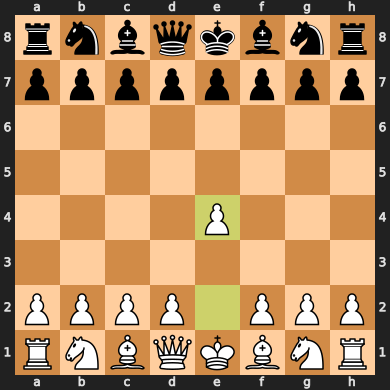

In [8]:
board

In [84]:
import gym_chess
import gym

In [10]:
env = gym.make('Chess-v0')
state = env.reset()
type(state)

chess.Board

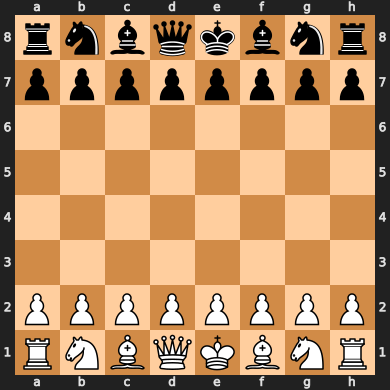

In [21]:
state

In [26]:
import random
next_state, *_ = env.step(random.choice(env.legal_moves))

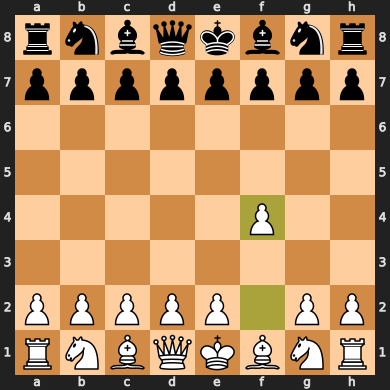

In [27]:
next_state

In [28]:
env.legal_moves

[Move.from_uci('g8h6'),
 Move.from_uci('g8f6'),
 Move.from_uci('b8c6'),
 Move.from_uci('b8a6'),
 Move.from_uci('h7h6'),
 Move.from_uci('g7g6'),
 Move.from_uci('f7f6'),
 Move.from_uci('e7e6'),
 Move.from_uci('d7d6'),
 Move.from_uci('c7c6'),
 Move.from_uci('b7b6'),
 Move.from_uci('a7a6'),
 Move.from_uci('h7h5'),
 Move.from_uci('g7g5'),
 Move.from_uci('f7f5'),
 Move.from_uci('e7e5'),
 Move.from_uci('d7d5'),
 Move.from_uci('c7c5'),
 Move.from_uci('b7b5'),
 Move.from_uci('a7a5')]

In [19]:
from mlrl.maze.maze_env import make_maze_env

In [37]:
maze_env = make_maze_env(seed=0, maze_size=(5, 5))

In [85]:
alpha_zero_env = gym.make('ChessAlphaZero-v0')

In [92]:
alpha_obs = alpha_zero_env.reset()
alpha_obs.shape

(8, 8, 119)

In [88]:
alpha_zero_env.action_space.n

4672

In [11]:
from mlrl.chess.chess_env import ChessVsRandom
import random

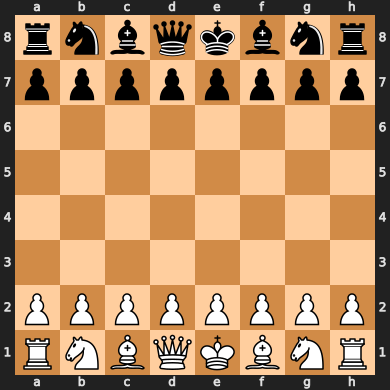

In [12]:
env = ChessVsRandom()
env.reset()

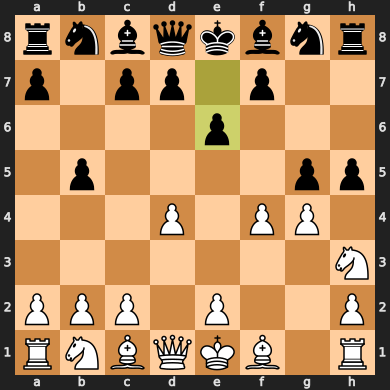

In [27]:
import random
env.step(random.choice(env.legal_moves))
env._board

In [1]:
from mlrl.meta.q_estimation import QFunction
from mlrl.chess.chess_state import ChessState

import badgyal
import chess
import chess.svg


class ChessQFunction(QFunction):

    def __init__(self):
        self.network = badgyal.BGNet(cuda=True)

    def compute_q(self, state: ChessState, action: chess.Move) -> float:
        board = chess.Board()
        board.set_epd(state.board_epd)
        policy, _ = self.network.eval(board, softmax_temp=1.61)
        return policy[action.uci()]

In [2]:
from mlrl.meta.search_tree import SearchTree
from mlrl.meta.meta_env import MetaEnv
from mlrl.chess.chess_env import ChessVsRandom


env = ChessVsRandom()
env.reset()

q_hat = ChessQFunction()
initial_tree = SearchTree(env, ChessState.extract_state(env))
meta_env = MetaEnv(env, q_hat, initial_tree, max_tree_size=10)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


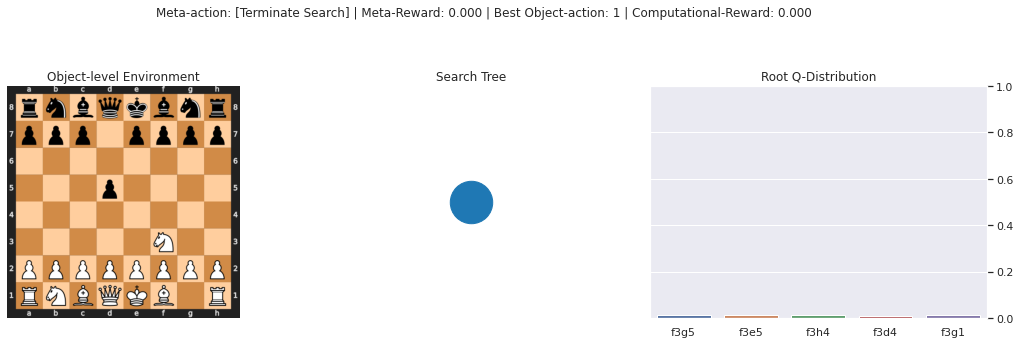

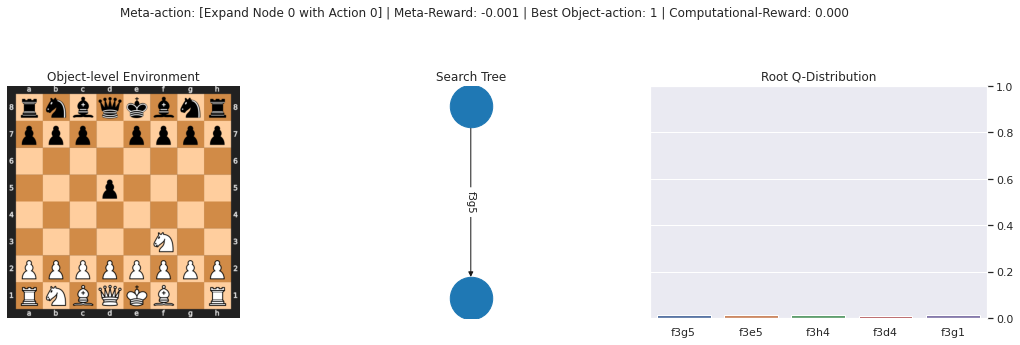

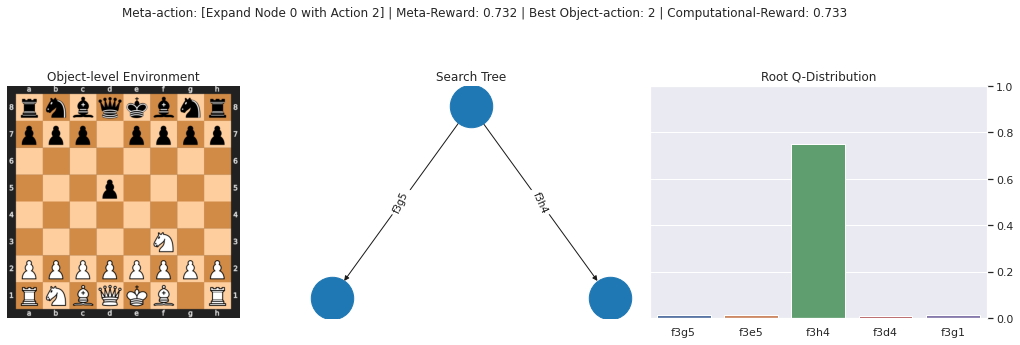

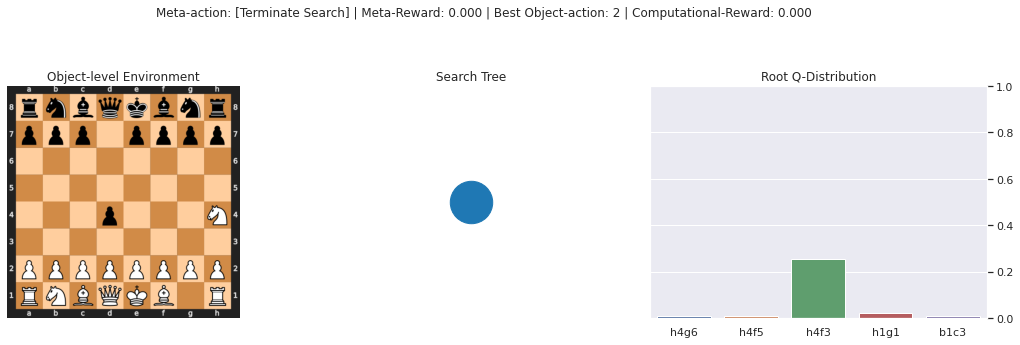

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

meta_env.render(plt_show=True);
meta_env.step(1)
meta_env.render(plt_show=True);
meta_env.step(3)
meta_env.render(plt_show=True);
meta_env.step(0)
meta_env.render(plt_show=True);